# Introduction
This code tests the proposed model on Wisconsin Breast Cancer Database (https://www.kaggle.com/datasets/roustekbio/breast-cancer-csv).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

%matplotlib inline 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils



#Import models from scikit learn module:
from sklearn import datasets,metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#For timing the simulation
import time

# Parameters

In [2]:
epoch=30

# Loading BCD Data

In [3]:
#load dataset
data = pd.read_csv("/kaggle/input/bcd-dataset/breastCancer.csv",header = 0)
data.head(5)

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


# Data Preprocessing

class
2    458
4    241
Name: count, dtype: int64


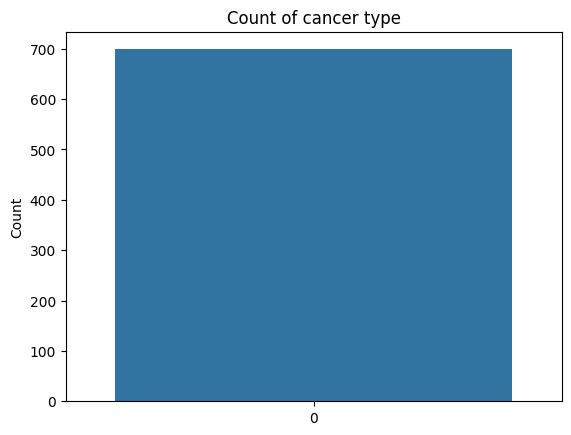

In [4]:
print(data['class'].value_counts())
plt.title('Count of cancer type')
sns.countplot(data['class'])
plt.ylabel('Count')
plt.show()

In [5]:
#clean and prepare data
data.drop('id',axis=1,inplace=True)

# size of the dataframe
len(data)

699

<Axes: >

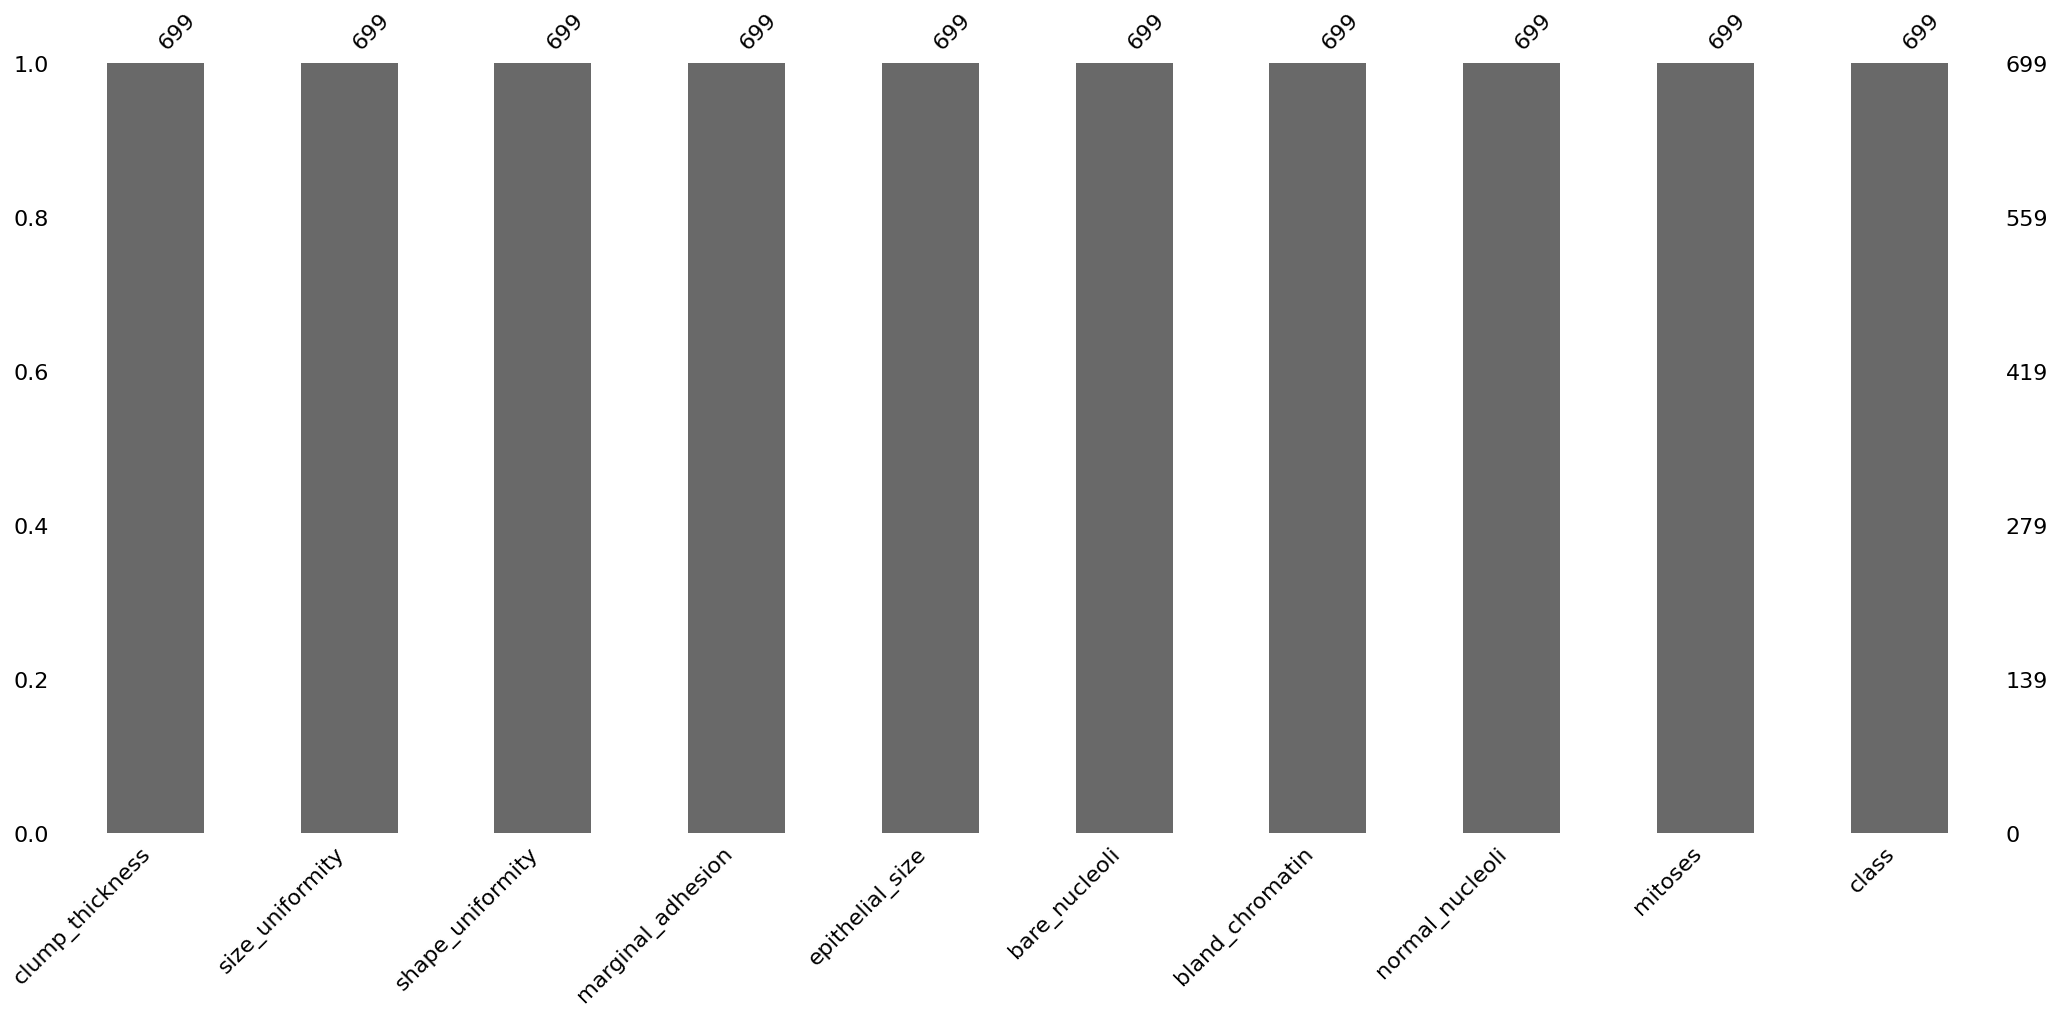

In [6]:
import missingno as msno
msno.bar(data)

In [7]:
data.isnull().sum()

clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithelial_size      0
bare_nucleoli        0
bland_chromatin      0
normal_nucleoli      0
mitoses              0
class                0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   clump_thickness    699 non-null    int64 
 1   size_uniformity    699 non-null    int64 
 2   shape_uniformity   699 non-null    int64 
 3   marginal_adhesion  699 non-null    int64 
 4   epithelial_size    699 non-null    int64 
 5   bare_nucleoli      699 non-null    object
 6   bland_chromatin    699 non-null    int64 
 7   normal_nucleoli    699 non-null    int64 
 8   mitoses            699 non-null    int64 
 9   class              699 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


## Lets remove "?" in column 7 to have int dtype

In [9]:
(data['bare_nucleoli']== '?').sum()    

16

In [10]:
data = data[data.bare_nucleoli != '?']
len(data)

683

In [11]:

data=data.astype({"bare_nucleoli":int})

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   clump_thickness    683 non-null    int64
 1   size_uniformity    683 non-null    int64
 2   shape_uniformity   683 non-null    int64
 3   marginal_adhesion  683 non-null    int64
 4   epithelial_size    683 non-null    int64
 5   bare_nucleoli      683 non-null    int64
 6   bland_chromatin    683 non-null    int64
 7   normal_nucleoli    683 non-null    int64
 8   mitoses            683 non-null    int64
 9   class              683 non-null    int64
dtypes: int64(10)
memory usage: 58.7 KB


In [13]:
print(data['class'].value_counts())

class
2    444
4    239
Name: count, dtype: int64


## Proper labeling

The classes are 2 and 4, lets make them 0, 1, making the label better

In [14]:
Y=data['class']
Y=Y.map({2:0,4:1})

print(Y.shape)
print(type(Y))

(683,)
<class 'pandas.core.series.Series'>


In [15]:
data.drop('class',axis=1,inplace=True)
X=data
del data

## Oversampling

In [16]:
from imblearn.over_sampling import KMeansSMOTE
oversample = KMeansSMOTE()
X, Y = oversample.fit_resample(X, Y)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
Y1=pd.DataFrame(Y)
print(Y1.value_counts())

class
1        447
0        444
Name: count, dtype: int64


## Creating one-hot class

In [18]:
Y = utils.to_categorical(Y, num_classes=2)

## Split train and test dataset

In [19]:
X_train,X_test,y_train,y_test= train_test_split(X,Y,test_size=0.15,stratify=Y)

In [20]:
y_test.shape

(134, 2)

## Scaling

In [21]:
scaler=StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(X_train.shape, X_test)

((757, 9),
 array([[-1.40242445, -0.89064602, -0.93831527, ..., -1.17602756,
         -0.75129281, -0.37898275],
        [-0.04396596,  0.45308898,  0.42634306, ..., -0.37073325,
         -0.75129281, -0.37898275],
        [-1.40242445, -0.89064602, -0.93831527, ..., -1.17602756,
         -0.75129281, -0.37898275],
        ...,
        [-0.7231952 , -0.89064602, -0.93831527, ...,  0.43456107,
          1.42298387, -0.37898275],
        [ 0.29564866, -0.89064602, -0.93831527, ..., -1.17602756,
         -0.75129281, -0.37898275],
        [-1.06280982, -0.21877852, -0.93831527, ..., -1.17602756,
         -0.75129281, -0.37898275]]))

## Reshaping
Reshaping the data set to 3D to pass it through CNN

In [22]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((757, 9), (134, 9), (757, 2), (134, 2))

In [23]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

# Create teacher and student model

In [24]:
# Create the teacher
teacher =keras.Sequential()
teacher.add(keras.Input(shape=(X_train.shape[1],1)))
teacher.add(keras.layers.Conv1D(filters=64,kernel_size= 2,activation='relu'))
teacher.add(keras.layers.BatchNormalization())
teacher.add(keras.layers.Dropout(0.2))
        
teacher.add(keras.layers.Conv1D(448, 2,activation='relu'))
teacher.add(keras.layers.BatchNormalization())
teacher.add(keras.layers.Dropout(0.2))
        
teacher.add(keras.layers.Flatten())
teacher.add(keras.layers.Dense(64,activation='relu'))
teacher.add(keras.layers.Dropout(0.2))

teacher.add(keras.layers.Dense(2,activation='sigmoid'))

teacher.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',
              metrics=['accuracy'])


# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[1], 1)),
        layers.Conv1D(4, 2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
       # layers.LeakyReLU(alpha=0.2),
        
        layers.Conv1D(8, 2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(2,activation='sigmoid'),
    ],
    name="student",)
    

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

#compile STUDENT
student_scratch.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',
              metrics=['accuracy'])
print( sep='\n')
print('STUDENT')
    


STUDENT


Lets make a copy of the student model for comparion

In [25]:
teacher.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 448)         │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 448)         │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 448)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,930 (1019.26 KB)

 Trainable params: 259,906 (1015.26 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [26]:
student.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 8, 4)           │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7, 8)           │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246 (984.00 B)

 Trainable params: 222 (888.00 B)

 Non-trainable params: 24 (96.00 B)

# Train teacher model

In [27]:
start_time = time.time()
teacher_history=teacher.fit(X_train,y_train,epochs=epoch,validation_data=(X_test,y_test),verbose=1)
end_time = time.time()
print( sep='\n')

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7303 - loss: 0.5971 - val_accuracy: 0.9627 - val_loss: 0.5770
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9809 - loss: 0.0783 - val_accuracy: 0.9776 - val_loss: 0.5416
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9823 - loss: 0.0603 - val_accuracy: 0.9776 - val_loss: 0.5168
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9759 - loss: 0.0870 - val_accuracy: 0.9776 - val_loss: 0.4952
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9663 - loss: 0.1018 - val_accuracy: 0.9776 - val_loss: 0.4697
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9734 - loss: 0.0806 - val_accuracy: 0.9776 - val_loss: 0.4302
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9667 - loss: 0.0885 - val_accuracy: 0.9776 - val_loss: 0.3784
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9748 - loss: 0.0668 - val_accuracy: 0.9776 - v

In [28]:
teacher.evaluate(X_test,y_test)
print("Execution time: ", end_time - start_time,"secs")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0247 
Execution time:  11.331736326217651 secs


# Student Model without KD Training

In [29]:
start_time = time.time()
student_scratch_history=student_scratch.fit(X_train,y_train,epochs=epoch,validation_data=(X_test,y_test),verbose=1)
end_time = time.time()
print( sep='\n')

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3490 - loss: 1.0158 - val_accuracy: 0.1642 - val_loss: 0.8434
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3765 - loss: 0.9572 - val_accuracy: 0.2015 - val_loss: 0.8279
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4119 - loss: 0.9049 - val_accuracy: 0.2836 - val_loss: 0.8113
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4260 - loss: 0.9029 - val_accuracy: 0.3507 - val_loss: 0.7930
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4636 - loss: 0.8899 - val_accuracy: 0.4179 - val_loss: 0.7719
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4954 - loss: 0.8363 - val_accuracy: 0.4478 - val_loss: 0.7495
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5410 - loss: 0.8186 - val_accuracy: 0.5373 - val_loss: 0.7253
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5500 - loss: 0.8038 - val_accuracy: 0.5970 - val_loss

In [30]:
student_scratch.evaluate(X_test,y_test)
print("Execution time: ", end_time - start_time,"secs")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9654 - loss: 0.2867 
Execution time:  6.1984498500823975 secs


# Knowledge Distillation
## Construct distiller class

In [31]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    
    def call(self, x):
        return self.student(x)

In [32]:
 # Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(optimizer=keras.optimizers.Adam(),
metrics=['accuracy'],
student_loss_fn= keras.losses.BinaryCrossentropy() ,
distillation_loss_fn=keras.losses.KLDivergence(),
alpha=0.1,
temperature=10,
)

## Distill teacher to student


In [33]:
print( sep='\n')
print('DISTILL TEACHER TO STUDENT')
start_time = time.time()
kd_history=distiller.fit(X_train, y_train, epochs=epoch, verbose=1, validation_data=(X_test,y_test))
end_time = time.time()
print( sep='\n')


DISTILL TEACHER TO STUDENT
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7407 - distillation_loss: 7.2993e-04 - loss: 0.4717 - student_loss: 0.5559 - val_accuracy: 0.9328 - val_loss: 0.5070 - val_student_loss: 0.5405
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9145 - distillation_loss: 3.6171e-04 - loss: 0.4996 - student_loss: 0.3193 - val_accuracy: 0.9478 - val_loss: 0.5031 - val_student_loss: 0.4347
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9490 - distillation_loss: 2.2186e-04 - loss: 0.4999 - student_loss: 0.2188 - val_accuracy: 0.9701 - val_loss: 0.5007 - val_student_loss: 0.3637
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9401 - distillation_loss: 1.4081e-04 - loss: 0.5056 - student_loss: 0.1630 - val_accuracy: 0.9701 - val_loss: 0.4999 - val_student_loss: 0.3155
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9663 - distillation_loss: 1.2650e-04 - loss: 0.4988 - student_loss: 0.1482 - val_accuracy: 0.9701 - val_loss: 0.49

In [34]:
distiller.evaluate(X_test,y_test)
print("Execution time: ", end_time - start_time,"secs")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9773 - loss: 0.5001 - student_loss: 0.0611 
Execution time:  7.769648313522339 secs


# Confusion Matrix Teacher

In [35]:
y_predt=teacher.predict(X_test)

#Confusion matrix
cm=metrics.confusion_matrix(y_test.argmax(axis=1),y_predt.argmax(axis=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


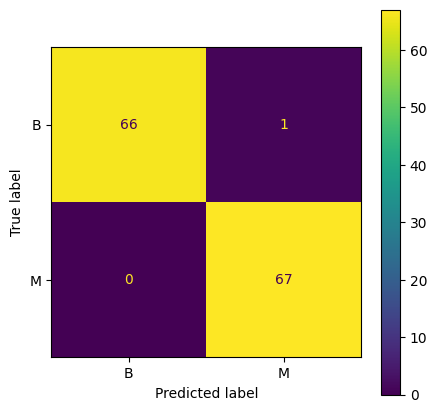

In [36]:
#Plot
disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['B','M'],)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax);

# Confusion Matrix Student with KD

In [37]:
y_preds=distiller.predict(X_test)

#Confusion matrix
cm=metrics.confusion_matrix(y_test.argmax(axis=1),y_preds.argmax(axis=1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


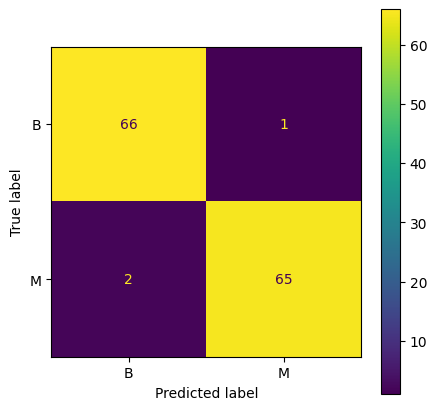

In [38]:
#Plot
disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['B','M'],)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax);

#plt.savefig("CM2.svg")

In [39]:
auc_roc=metrics.roc_auc_score(y_test.argmax(axis=1),y_preds.argmax(axis=1))
auc_roc

0.9776119402985073

In [40]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.argmax(axis=1),y_preds.argmax(axis=1))
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9776119402985073

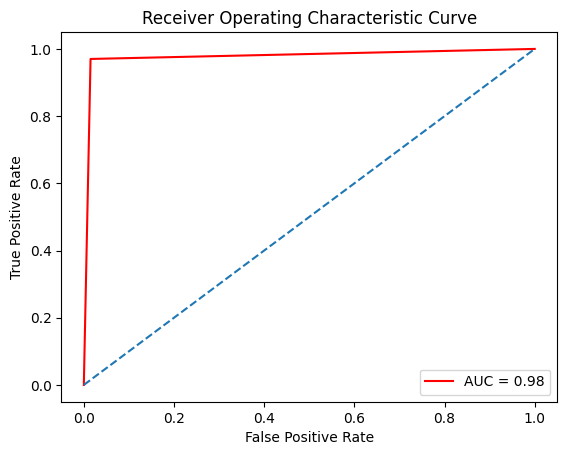

In [41]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("roc2.svg")

# Plots of accuracy and loss 

## Accuracy and loss function

In [42]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.grid(visible=True)
  plt.show()
  #plt.savefig("Tacc.svg")

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.grid(visible=True)
  plt.show()
  #plt.savefig("Tloss.svg")

## Plot of teacher

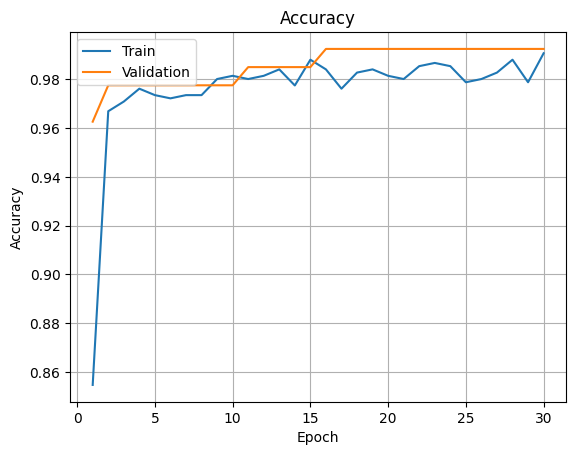

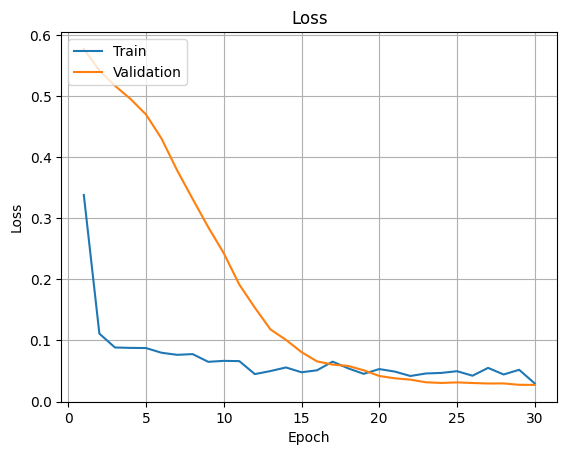

In [43]:
plotLearningCurve(teacher_history,epoch)

## KD accuracy and loss function

In [44]:
def plotKDCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Student Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.grid(visible=True)
  plt.savefig("SmAcc.svg")
  plt.show()

  plt.plot(epochRange,history.history['student_loss'])
  plt.plot(epochRange,history.history['val_student_loss'])
  plt.title('Student Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.grid(visible=True)
  plt.savefig("SmLoss.svg")
  plt.show()

## Plot of Student Model with KD

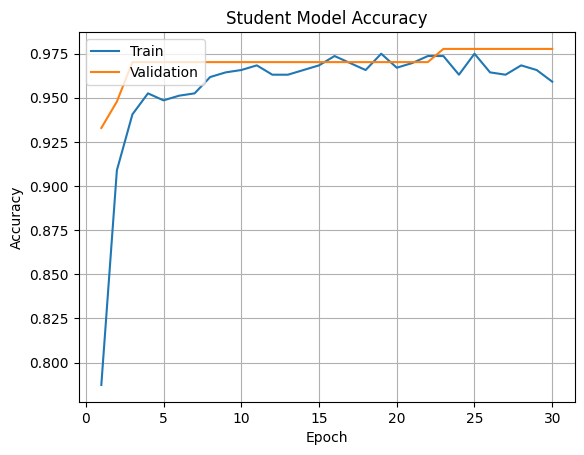

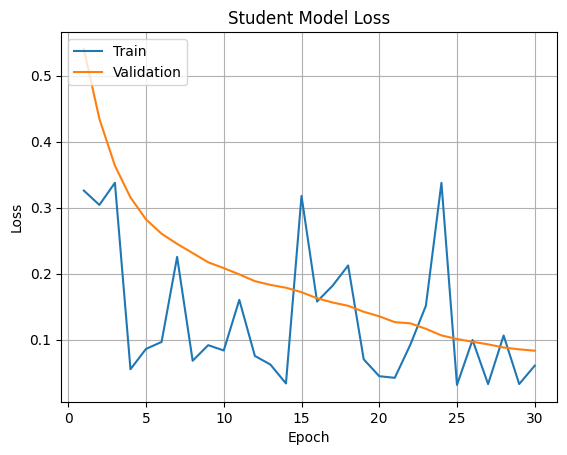

In [45]:
plotKDCurve(kd_history,epoch)

## Plotting Student scratch Model

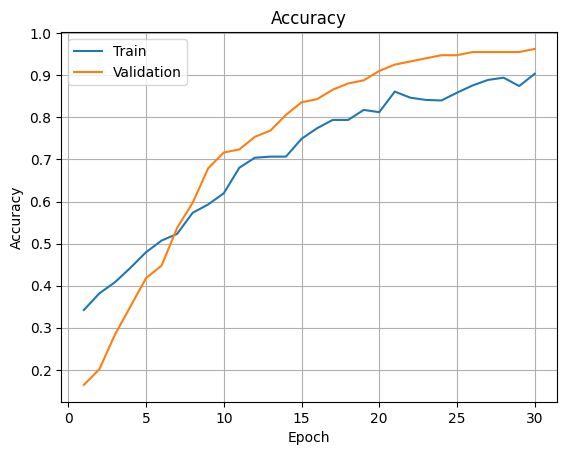

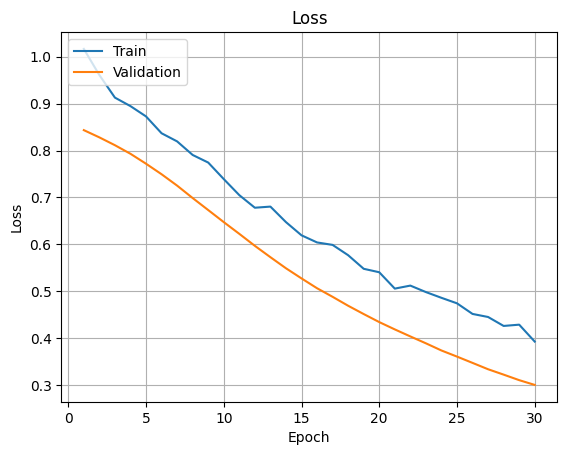

In [46]:
plotLearningCurve(student_scratch_history,epoch)

## Accuracy and loss of Teacher vs Student KD model 

In [47]:
def plotKDCurveProf(his,tHis,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,tHis.history['accuracy'])
  plt.plot(epochRange,tHis.history['val_accuracy'])
  plt.plot(epochRange,his.history['accuracy'])
  plt.plot(epochRange,his.history['val_accuracy'])

  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['T_train','T_val','KD_train','KD_val'],loc='lower right')
  plt.grid(visible=True)
  plt.savefig("T-Sacc.svg")
  plt.show()


  plt.plot(epochRange,tHis.history['loss'])
  plt.plot(epochRange,tHis.history['val_loss'])
  plt.plot(epochRange,his.history['student_loss'])
  plt.plot(epochRange,his.history['val_student_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['T_train','T_val','KD_train','KD_val'],loc='upper left')
  plt.grid(visible=True)
  plt.savefig("T-Sloss.svg")
  plt.show()

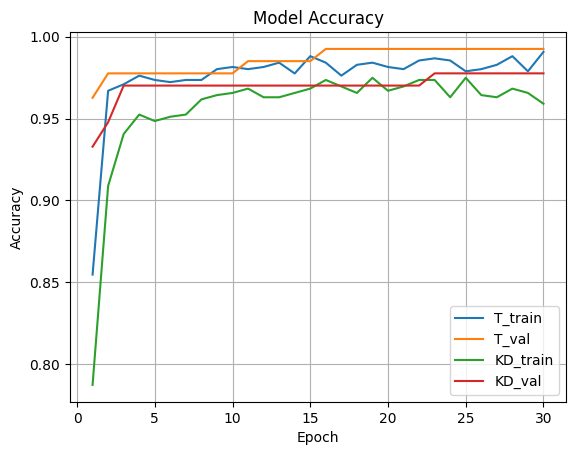

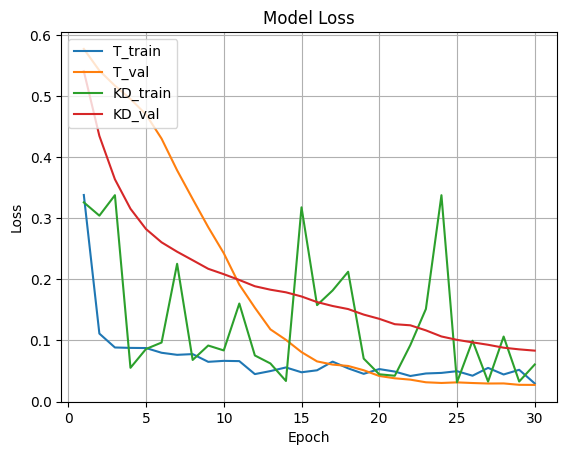

In [49]:
plotKDCurveProf(kd_history,teacher_history,epoch)

 ## Student with KD Vs Student without Kd Accuracy and loss

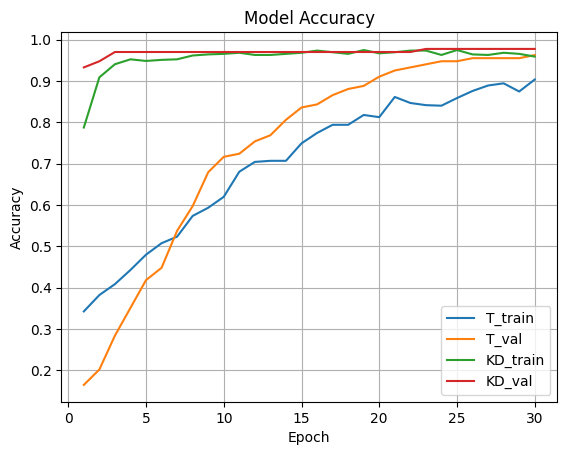

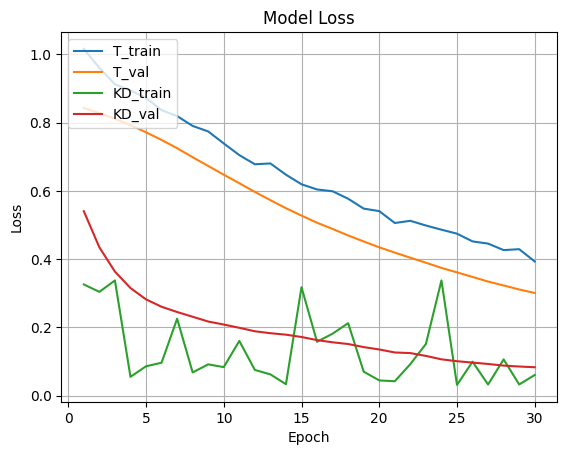

In [50]:
plotKDCurveProf(kd_history,student_scratch_history,epoch)

# Results Summary

In [51]:
print("Vals. \t\t TM \t SM_scratch \t SM")
print("="*50)
print("Acc. \t\t %.2f \t %.2f \t\t %.2f"%(teacher_history.history['accuracy'][epoch-1],student_scratch_history.history['accuracy'][epoch-1],kd_history.history['accuracy'][epoch-1]))
print("Val. Acc. \t %.2f \t %.2f \t\t %.2f"%(teacher_history.history['val_accuracy'][epoch-1],student_scratch_history.history['val_accuracy'][epoch-1],kd_history.history['val_accuracy'][epoch-1]))
print("Loss. \t\t %.2f \t %.2f \t\t %.2f"%(teacher_history.history['loss'][epoch-1],student_scratch_history.history['loss'][epoch-1],kd_history.history['loss'][epoch-1]))
print("Val. Loss. \t %.2f \t %.2f \t\t %.2f"%(teacher_history.history['val_loss'][epoch-1],student_scratch_history.history['val_loss'][epoch-1],kd_history.history['val_loss'][epoch-1]))

Vals. 		 TM 	 SM_scratch 	 SM
Acc. 		 0.99 	 0.90 		 0.96
Val. Acc. 	 0.99 	 0.96 		 0.98
Loss. 		 0.03 	 0.39 		 0.50
Val. Loss. 	 0.03 	 0.30 		 0.50
